In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import time
import scipy.optimize as so
from scipy.stats import pearsonr

%matplotlib inline

In [2]:
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8'),\
     ('mu_ra_mu_dec_cov','<f8'),('mu_ra_plx_cov','<f8'),('mu_dec_plx_cov','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(16):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']
    tgas['dec'] = tgas_tmp['dec']
    tgas['mu_ra'] = tgas_tmp['pmra']
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']
    tgas['mu_dec'] = tgas_tmp['pmdec']
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']
    tgas['plx'] = tgas_tmp['parallax']
    tgas['plx_err'] = tgas_tmp['parallax_error']
    tgas['mu_ra_mu_dec_cov'] = tgas_tmp['pmra_pmdec_corr']*tgas_tmp['pmra_error']*tgas_tmp['pmdec_error']
    tgas['mu_ra_plx_cov'] = tgas_tmp['parallax_pmra_corr']*tgas_tmp['parallax_error']*tgas_tmp['pmra_error']
    tgas['mu_dec_plx_cov'] = tgas_tmp['parallax_pmdec_corr']*tgas_tmp['parallax_error']*tgas_tmp['pmdec_error']

    tgas_full = np.append(tgas_full, tgas)


../data/TGAS/TgasSource_000-000-000.csv
../data/TGAS/TgasSource_000-000-001.csv
../data/TGAS/TgasSource_000-000-002.csv
../data/TGAS/TgasSource_000-000-003.csv
../data/TGAS/TgasSource_000-000-004.csv
../data/TGAS/TgasSource_000-000-005.csv
../data/TGAS/TgasSource_000-000-006.csv
../data/TGAS/TgasSource_000-000-007.csv
../data/TGAS/TgasSource_000-000-008.csv
../data/TGAS/TgasSource_000-000-009.csv
../data/TGAS/TgasSource_000-000-010.csv
../data/TGAS/TgasSource_000-000-011.csv
../data/TGAS/TgasSource_000-000-012.csv
../data/TGAS/TgasSource_000-000-013.csv
../data/TGAS/TgasSource_000-000-014.csv
../data/TGAS/TgasSource_000-000-015.csv


In [35]:
t = tgas_full
print len(t)

2057050


-0.5463185
-0.6795493


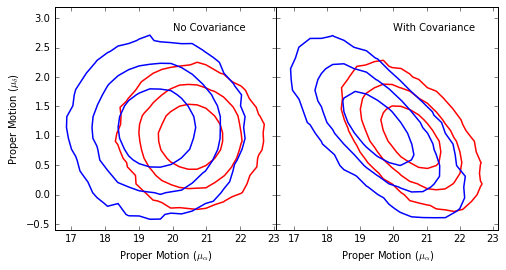

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))



# Need this function
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level


def generate_plot(mu_ra, mu_dec, ax, nbins_x=20, nbins_y=20, color='k'):
    
    H, xedges, yedges = np.histogram2d(mu_ra, mu_dec, bins=(nbins_x,nbins_y), normed=True)

    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))
    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.683))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.954))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.9973))
    levels = [one_sigma, two_sigma, three_sigma]
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    contour = ax.contour(X, Y, Z, levels=levels[::-1], origin="lower", colors=color, linewidth=1.5)
    zc = contour.collections
    plt.setp(zc, linewidth=1.5)


    
    
    
    
# id1 = 756
# id2 = 757
id1 = 1195
id2 = 1196

# Non-correlated
ran_pm_1_x = np.random.normal(loc=t['mu_ra'][id1], scale=t['mu_ra_err'][id1], size=100000)
ran_pm_1_y = np.random.normal(loc=t['mu_dec'][id1], scale=t['mu_dec_err'][id1], size=100000)
generate_plot(ran_pm_1_x, ran_pm_1_y, ax[0], color='r')

ran_pm_2_x = np.random.normal(loc=t['mu_ra'][id2], scale=t['mu_ra_err'][id2], size=100000)
ran_pm_2_y = np.random.normal(loc=t['mu_dec'][id2], scale=t['mu_dec_err'][id2], size=100000)
generate_plot(ran_pm_2_x, ran_pm_2_y, ax[0], color='b')


# Correlated
print t['mu_ra_mu_dec_cov'][id1]/t['mu_ra_err'][id1]/t['mu_dec_err'][id1]
mu_ran_1 = np.array([t['mu_ra'][id1], t['mu_dec'][id1]])
mu_cov_1 = np.array([[t['mu_ra_err'][id1]**2,t['mu_ra_mu_dec_cov'][id1]],[t['mu_ra_mu_dec_cov'][id1], t['mu_dec_err'][id1]**2]])
ran_samples_1 = np.random.multivariate_normal(mean=mu_ran_1, cov=mu_cov_1, size=100000)
generate_plot(ran_samples_1[:,0], ran_samples_1[:,1], ax[1], color='r')

print t['mu_ra_mu_dec_cov'][id2]/t['mu_ra_err'][id2]/t['mu_dec_err'][id2]
mu_ran_2 = np.array([t['mu_ra'][id2], t['mu_dec'][id2]])
#mu_cov_2 = np.array([[t['mu_ra_err'][id2],0.0],[0.0, t['mu_dec_err'][id2]]])
mu_cov_2 = np.array([[t['mu_ra_err'][id2]**2,t['mu_ra_mu_dec_cov'][id2]],[t['mu_ra_mu_dec_cov'][id2], t['mu_dec_err'][id2]**2]])
ran_samples_2 = np.random.multivariate_normal(mean=mu_ran_2, cov=mu_cov_2, size=100000)
generate_plot(ran_samples_2[:,0], ran_samples_2[:,1], ax[1], color='b')


ax[0].set_xlabel(r'Proper Motion ($\mu_{\alpha}$)')
ax[0].set_ylabel(r'Proper Motion ($\mu_{\delta}$)')
ax[1].set_xlabel(r'Proper Motion ($\mu_{\alpha}$)')

ax[0].set_ylim(-0.6, 3.2)
ax[1].set_ylim(-0.6, 3.2)
ax[1].set_yticklabels([])

ax[0].text(20.0, 2.8, 'No Covariance')
ax[1].text(20.0, 2.8, 'With Covariance')

#ax[0].axis('equal')
#ax[1].axis('equal')

fig.subplots_adjust(wspace=0.0, left=0.10, right=0.98)
#plt.tight_layout()
plt.savefig('../figures/TGAS_covariance_proper_motion.pdf')

#plt.show()

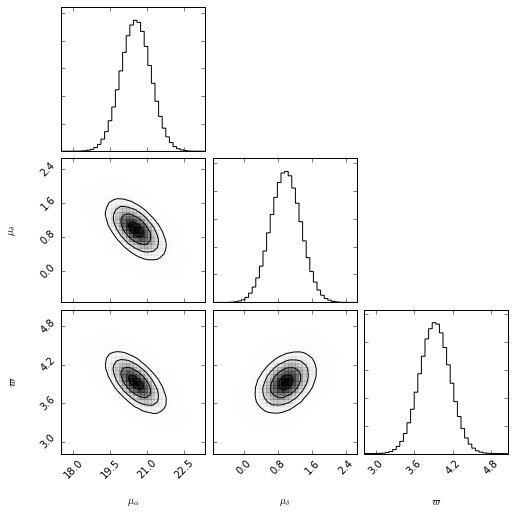

In [56]:
import corner

mu_ran = np.array([t['mu_ra'][id1], t['mu_dec'][id1], t['plx'][id1]])
mu_cov = np.array([[t['mu_ra_err'][id1]**2, t['mu_ra_mu_dec_cov'][id1], t['mu_ra_plx_cov'][id1]], \
                   [t['mu_ra_mu_dec_cov'][id1], t['mu_dec_err'][id1]**2, t['mu_dec_plx_cov'][id1]], \
                   [t['mu_ra_plx_cov'][id1], t['mu_dec_plx_cov'][id1], t['plx_err'][id1]**2]])
ran_samples = np.random.multivariate_normal(mean=mu_ran, cov=mu_cov, size=1000000)

hist2d_kwargs = {"plot_datapoints" : False}
labels=[r'$\mu_{\alpha}$', r'$\mu_{\delta}$', r'$\varpi$']
corner.corner(ran_samples, bins=40, labels=labels, **hist2d_kwargs)


plt.savefig('../figures/TGAS_covariance_corner.pdf')
#plt.show()

# mu_ran = np.array([t['mu_dec'][id2], t['mu_ra'][id2]])
# #mu_cov = np.array([[t['mu_ra_err'][id2]**2,t['mu_ra_mu_dec_cov'][id2]],[t['mu_ra_mu_dec_cov'][id2], t['mu_dec_err'][id2]**2]])
# mu_cov = np.array([[t['mu_dec_err'][id2]**2,t['mu_ra_mu_dec_cov'][id2]],[t['mu_ra_mu_dec_cov'][id2], t['mu_ra_err'][id2]**2]])
# ran_samples = np.random.multivariate_normal(mean=mu_ran, cov=mu_cov, size=1000000)

# print pearsonr(ran_samples[:,0], ran_samples[:,1])[0]


In [86]:
from scipy.stats import multivariate_normal

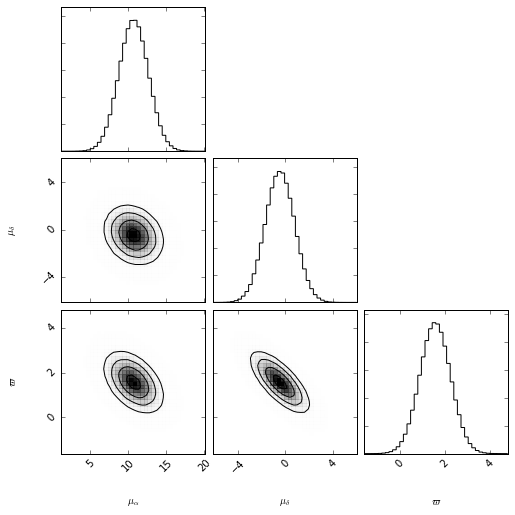

In [92]:


mu_ran = np.array([t['mu_ra'][id1], t['mu_dec'][id1], t['plx'][id1]])
mu_cov = np.array([[t['mu_ra_err'][id1]**2, t['mu_ra_mu_dec_cov'][id1], t['mu_ra_plx_cov'][id1]], \
                   [t['mu_ra_mu_dec_cov'][id1], t['mu_dec_err'][id1]**2, t['mu_dec_plx_cov'][id1]], \
                   [t['mu_ra_plx_cov'][id1], t['mu_dec_plx_cov'][id1], t['plx_err'][id1]**2]])
astrometry = multivariate_normal(mean=mu_ran, cov=mu_cov)

samples = astrometry.rvs(size=1000000)


hist2d_kwargs = {"plot_datapoints" : False}
labels=[r'$\mu_{\alpha}$', r'$\mu_{\delta}$', r'$\varpi$']
corner.corner(samples, bins=40, labels=labels, **hist2d_kwargs)

plt.show()
